In [1]:
import torch
print(torch.cuda.is_available()) 
print(torch.cuda.get_device_name(0)) 

True
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [2]:
import yfinance as yf 
import duckdb
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torch.nn import Module
from datetime import datetime

import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri("http://localhost:5000")  # Adjust to your MLflow server URI
mlflow.set_experiment("Stock Prediction")

torch.set_num_threads(12)
torch.set_num_interop_threads(12)
    
class StockPrediction():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def load_yfinance_data(self, enterprise, start_date, end_date):
        yf_df = yf.download(enterprise, start=start_date, end=end_date).reset_index()

        ds = duckdb.sql(f"""
            DROP TABLE IF EXISTS finance;
            CREATE TABLE finance AS ( 
                SELECT
                "('Date', '')" as dt_time
                ,date_trunc('day', "('Date', '')") as dt
                ,"('Adj Close', '{enterprise}')" as adj_close
                ,"('Close', '{enterprise}')" as close
                ,"('High', '{enterprise}')" as high
                ,"('Low', '{enterprise}')" as low
                ,"('Open', '{enterprise}')" as open
                ,"('Volume', '{enterprise}')" as volume

                FROM yf_df
            )
            """)
        
    def get_yfinance_dataset(self):
        finance_dataset = duckdb.sql("""
            SELECT         
                * 
            FROM finance
                """)    
        

        #finance_dataset.show()
        
        return finance_dataset.df()
    
    def get_train_n_test(self, test_size = 0.65):
        yfinance_dataset = self.get_yfinance_dataset()

        timeseries = yfinance_dataset[["adj_close"]].values.astype('float32')
        dt_time = yfinance_dataset['dt']

        train_size = int(len(timeseries) * test_size)
        test_size = len(timeseries) - train_size
        train, test = timeseries[:train_size], timeseries[train_size:]
        dt_train, dt_test = dt_time[:train_size], dt_time[train_size:]

        return dt_train, train, dt_test, test
    
    def plot_yfinance_dataset(self, plot_test=False):    
        dt_train, train, dt_test, test = self.get_train_n_test()

        
        if (plot_test):
            dt_time = dt_test
            timeseries = test
        else:
            dt_time = dt_train
            timeseries = train            


        plt.plot(dt_time, timeseries)
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

        plt.xticks(rotation=45)
        plt.show()         


    def create_torch_dataset(self, dataset, lookback):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-lookback):
            feature = dataset[i:i+lookback]
            target = dataset[i+1:i+lookback+1]
            X.append(feature)
            y.append(target)
        return torch.tensor(X).to(self.device), torch.tensor(y).to(self.device)
    
    def get_torch_train_n_test(self, test_percentage = 0.65, lookback = 4):
        _x_train, _y_train, _x_test, _y_test = self.get_train_n_test(0.65)
        
        x_train, y_train = self.create_torch_dataset(_y_train, lookback=lookback)
        x_test, y_test = self.create_torch_dataset(_y_test, lookback=lookback) 

        return x_train, y_train, x_test, y_test
    
    def train_model(self, model: Module, x_train, y_train, x_test, y_test, n_epochs=100, weight_decay=1e-4):
            self.model = model.to(self.device)

            optimizer = optim.Adam(self.model.parameters(), weight_decay=weight_decay)
            loss_fn = nn.MSELoss()
            loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=8)

            run_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            # Start an MLflow run
            with mlflow.start_run(run_name=f"StockPrediction_{run_timestamp}", nested=False):
                # Log model parameters
                mlflow.log_param("n_epochs", n_epochs)
                mlflow.log_param("weight_decay", weight_decay)

                for epoch in range(n_epochs):
                    self.model.train()
                    for X_batch, y_batch in loader:
                        X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                        y_pred = self.model(X_batch)
                        loss = loss_fn(y_pred, y_batch)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # Validation
                    if (epoch % 10 == 0) or (epoch == n_epochs - 1):  # Log metrics every 10 epochs
                        self.model.eval()
                        with torch.no_grad():
                            y_pred_train = self.model(x_train)
                            y_pred_test = self.model(x_test)

                            # Calculate metrics
                            train_loss = loss_fn(y_pred_train, y_train)
                            train_rmse = torch.sqrt(train_loss).item()
                            train_mae = torch.mean(torch.abs(y_train - y_pred_train)).item()
                            train_mape = (torch.mean(torch.abs((y_train - y_pred_train) / y_train)) * 100).item()

                            test_loss = loss_fn(y_pred_test, y_test)
                            test_rmse = torch.sqrt(test_loss).item()
                            test_mae = torch.mean(torch.abs(y_test - y_pred_test)).item()
                            test_mape = (torch.mean(torch.abs((y_test - y_pred_test) / y_test)) * 100).item()

                        # Log metrics
                        mlflow.log_metric("train_rmse", train_rmse, step=epoch)
                        mlflow.log_metric("train_mae", train_mae, step=epoch)
                        mlflow.log_metric("train_mape", train_mape, step=epoch)
                        mlflow.log_metric("test_rmse", test_rmse, step=epoch)
                        mlflow.log_metric("test_mae", test_mae, step=epoch)
                        mlflow.log_metric("test_mape", test_mape, step=epoch)

                        # Print metrics
                        print(f"Epoch {epoch}:")
                        print(f"  Train -> MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, MAPE: {train_mape:.2f}%")
                        print(f"  Test  -> MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, MAPE: {test_mape:.2f}%")

                # Log the model at the end of training
                mlflow.pytorch.log_model(self.model, "model")

    def test_model(self, model: Module, x_train, x_test, lookback=4):            
        yfinance_dataset = self.get_yfinance_dataset()
        test_size = 0.65

        timeseries = yfinance_dataset[["adj_close"]].values.astype('float32')
        train_size = int(len(timeseries) * test_size)

        with torch.no_grad():
            train_plot = np.ones((len(timeseries), 1)) * np.nan
            test_plot = np.ones((len(timeseries), 1)) * np.nan

            # Move tensors to CPU before converting to NumPy
            y_pred_train = model(x_train).cpu().numpy()[:, -1, :]
            y_pred_test = model(x_test).cpu().numpy()[:, -1, :]
            
            train_plot[lookback:lookback + len(y_pred_train), 0] = y_pred_train[:, 0]
            test_plot[train_size + lookback:train_size + lookback + len(y_pred_test), 0] = y_pred_test[:, 0]

            plt.plot(timeseries, label="Actual")
            plt.plot(train_plot, c='r', label="Train Predictions")
            plt.plot(test_plot, c='g', label="Test Predictions")
            plt.legend()
            plt.savefig("predictions_plot.png")  # Save the plot

            # Log plot as an artifact
            mlflow.log_artifact("predictions_plot.png")
            plt.show()

In [3]:
enterprise = 'GOOGL' 
start_date = '2024-09-20'  
end_date = '2024-11-20' 

stock_p  = StockPrediction()

stock_p.load_yfinance_data(enterprise, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
yfinance_dataset = stock_p.get_yfinance_dataset()

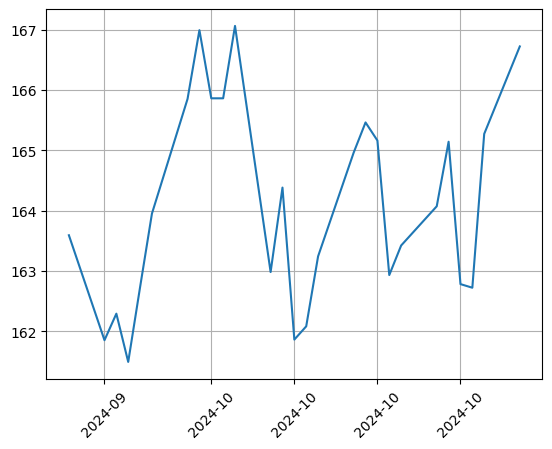

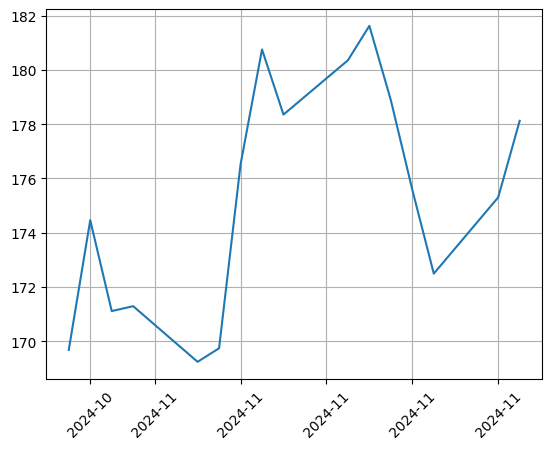

In [5]:
stock_p.plot_yfinance_dataset(False)
stock_p.plot_yfinance_dataset(True)

In [6]:
class StockModel(Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    
model = StockModel()

x_train, y_train, x_test, y_test = stock_p.get_torch_train_n_test()

stock_p.train_model(model, x_train, y_train, x_test, y_test, n_epochs = 10000)

/tmp/ipykernel_55458/3969506531.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X).to(self.device), torch.tensor(y).to(self.device)


Epoch 0:
  Train -> MAE: 164.5118, RMSE: 164.5197, MAPE: 100.21%
  Test  -> MAE: 176.1982, RMSE: 176.2483, MAPE: 100.20%
Epoch 10:
  Train -> MAE: 163.5382, RMSE: 163.5460, MAPE: 99.62%
  Test  -> MAE: 175.2252, RMSE: 175.2755, MAPE: 99.64%
Epoch 20:
  Train -> MAE: 161.6691, RMSE: 161.6773, MAPE: 98.48%
  Test  -> MAE: 173.3773, RMSE: 173.4283, MAPE: 98.59%
Epoch 30:
  Train -> MAE: 159.4442, RMSE: 159.4529, MAPE: 97.12%
  Test  -> MAE: 171.1302, RMSE: 171.1821, MAPE: 97.31%
Epoch 40:
  Train -> MAE: 157.8527, RMSE: 157.8619, MAPE: 96.15%
  Test  -> MAE: 169.5382, RMSE: 169.5909, MAPE: 96.41%
Epoch 50:
  Train -> MAE: 155.8969, RMSE: 155.9071, MAPE: 94.96%
  Test  -> MAE: 167.5787, RMSE: 167.6329, MAPE: 95.29%
Epoch 60:
  Train -> MAE: 154.0318, RMSE: 154.0433, MAPE: 93.83%
  Test  -> MAE: 165.7177, RMSE: 165.7734, MAPE: 94.24%
Epoch 70:
  Train -> MAE: 151.9434, RMSE: 151.9566, MAPE: 92.55%
  Test  -> MAE: 163.6246, RMSE: 163.6824, MAPE: 93.04%
Epoch 80:
  Train -> MAE: 150.1630, RMS

2024/11/21 15:08:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run StockPrediction_2024-11-21_14-58-09 at: http://localhost:5000/#/experiments/733130787373918098/runs/46dd9500d8f74d878f0c3c81a7c1bf53
🧪 View experiment at: http://localhost:5000/#/experiments/733130787373918098


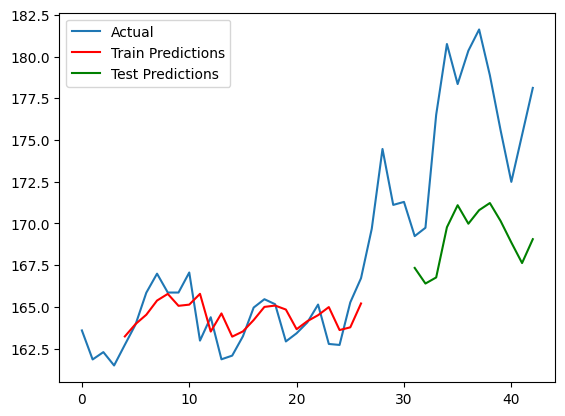

In [7]:
stock_p.test_model(model, x_train, x_test)